# Temporal Graph Network (TGN)
---



In [ ]:
# Imports & Libraries

import torch
import os
TORCH_VERSION = torch.__version__.split('+')[0]
CUDA_VERSION = torch.version.cuda
if CUDA_VERSION:
    CUDA_VERSION = "cu" + CUDA_VERSION.replace('.', '')
else:
    CUDA_VERSION = "cpu"
print(f"Installing for PyTorch {TORCH_VERSION} and {CUDA_VERSION}")
PYG_URL = f"https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_VERSION}.html"
!pip install torch-scatter torch-sparse -f {PYG_URL}
!pip install torch-geometric
!pip install torch-geometric-temporal
print("All libraries installed correctly!")

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.data import TemporalData
from torch_geometric.nn import TGNMemory
from torch_geometric.nn.models.tgn import IdentityMessage, LastAggregator
import logging
import sys
from tqdm import tqdm

In [ ]:
# -------------------------
# 1. Configuration & Logging
# -------------------------
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(linewidth=1000, profile="full")

log_filename = "training_tgn_robust.log"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    handlers=[
        logging.FileHandler(log_filename),
        logging.StreamHandler(sys.stdout)
    ],
    force=True
)
logger = logging.getLogger()
logger.info("Script started.")

2025-12-08 16:29:25,337 - Script started.


In [ ]:
# -------------------------
# 2. Load & Preprocess Data
# -------------------------
edges_file = "/disease_edges.csv"
df = pd.read_csv(edges_file)

# Convert to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True, errors='coerce')

# Drop invalid rows
if df['timestamp'].isna().any():
    n_dropped = df['timestamp'].isna().sum()
    logger.warning(f"Found {n_dropped} rows with invalid timestamps. Dropping them.")
    df = df.dropna(subset=['timestamp']).copy()

# Map raw node IDs to continuous integers
all_nodes = set(df['src'].unique()) | set(df['dst'].unique())
node_mapper = {code: i for i, code in enumerate(all_nodes)}

df['src'] = df['src'].map(node_mapper)
df['dst'] = df['dst'].map(node_mapper)
num_nodes = len(all_nodes)

logger.info(f"Events before reciprocal cleaning: {len(df)}")

# Create canonical pairs (min_id, max_id)
df['min_node'] = np.minimum(df['src'].values, df['dst'].values)
df['max_node'] = np.maximum(df['src'].values, df['dst'].values)

# Drop duplicates based on the canonical pair + timestamp (Reciprocal Training)
df = df.drop_duplicates(subset=['min_node', 'max_node', 'timestamp'])

# Clean up helper columns
df = df.drop(columns=['min_node', 'max_node'])
logger.info(f"Events after reciprocal cleaning: {len(df)}")

# Normalize timestamp for stability of TGN
t_raw = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds().values
t_log = np.log(t_raw + 1.0)
df['timestamp'] = (t_log * 1000.0).astype(np.int64)
df = df.sort_values('timestamp').reset_index(drop=True)

logger.info(f"Nodes: {num_nodes} | Events: {len(df)}")
logger.info(f"Time range (log-scaled int): {df['timestamp'].min()} to {df['timestamp'].max()}")

# Pack into PyG TemporalData object
data = TemporalData(
    src=torch.tensor(df['src'].values, dtype=torch.long),
    dst=torch.tensor(df['dst'].values, dtype=torch.long),
    t=torch.tensor(df['timestamp'].values, dtype=torch.long),
    msg=torch.ones(len(df), 16),
    y=torch.zeros(len(df), dtype=torch.long)
)

# Chronological Split (70% Train, 15% Val, 15% Test)
train_idx = int(len(data) * 0.70)
val_idx = int(len(data) * 0.85)
train_data = data[:train_idx]
val_data = data[train_idx:val_idx]
test_data = data[val_idx:]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")


2025-12-08 16:29:31,229 - Events before reciprocal cleaning: 6141197
2025-12-08 16:29:32,591 - Events after reciprocal cleaning: 6130189
2025-12-08 16:29:33,484 - Nodes: 28556 | Events: 6130189
2025-12-08 16:29:33,498 - Time range (log-scaled int): 0 to 21960
2025-12-08 16:29:33,672 - Using device: cuda


In [ ]:
# -------------------------
# 3. Model Components
# -------------------------
class SafeTGNMemory(TGNMemory):
    """
    Wrapper for TGNMemory to expose the underlying device property.
    """
    @property
    def device(self):
        return self.memory.device

class ScaledTimeEncoder(nn.Module):
    """
    Scales time differences before passing them to the base encoder.
    Useful because TimeEncoder often struggles with very large inputs.
    """
    def __init__(self, base_encoder, scale=1000.0):
        super().__init__()
        self.base_encoder = base_encoder
        self.scale = scale

    def forward(self, t):
        return self.base_encoder(t.float() / self.scale)

class GraphEmbedding(nn.Module):
    """
    The 'GNN' part. It takes the Node Memory (history) and the Time Difference,
    combines them, and produces a node embedding Z."""
    def __init__(self, in_channels, out_channels, time_enc):
        super().__init__()
        self.time_enc = time_enc
        input_dim = in_channels + out_channels
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )

    def forward(self, z, last_update, t):
        rel_t = t - last_update
        t_emb = self.time_enc(rel_t)
        x = torch.cat([z, t_emb], dim=-1)
        return self.mlp(x)

class LinkPredictor(nn.Module):
    """
    Standard MLP to predict probability of edge existence between two embeddings.
    """
    def __init__(self, in_channels):
        super().__init__()
        self.lin_1 = nn.Linear(in_channels * 2, in_channels)
        self.lin_2 = nn.Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = torch.cat([z_src, z_dst], dim=-1)
        return self.lin_2(self.lin_1(h).relu()).squeeze(-1)

In [ ]:
# -------------------------
# 4. Initialization
# -------------------------
memory_dim = 256
time_dim = 256
embedding_dim = 256
msg_dim = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Memory
memory = SafeTGNMemory(
    num_nodes=num_nodes,
    raw_msg_dim=msg_dim,
    memory_dim=memory_dim,
    time_dim=time_dim,
    message_module=IdentityMessage(msg_dim, memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

memory.time_enc = ScaledTimeEncoder(memory.time_enc).to(device)

gnn = GraphEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    time_enc=memory.time_enc,
).to(device)

predictor = LinkPredictor(embedding_dim).to(device)

optimizer = torch.optim.Adam(
    set(memory.parameters()) | set(gnn.parameters()) | set(predictor.parameters()),
    lr=0.0005
)
criterion = torch.nn.BCEWithLogitsLoss()

2025-12-08 16:30:05,357 - Start Training...


Training: 100%|██████████| 21456/21456 [10:28<00:00, 34.16it/s]


2025-12-08 16:42:51,048 - Epoch: 01, Loss: 0.5278 | Val AUC: 0.9557  AP: 0.9461  Hits@10: 0.9542


Training: 100%|██████████| 21456/21456 [10:28<00:00, 34.13it/s]


2025-12-08 16:55:38,637 - Epoch: 02, Loss: 0.5248 | Val AUC: 0.9479  AP: 0.9201  Hits@10: 0.9545


Training: 100%|██████████| 21456/21456 [10:28<00:00, 34.14it/s]


2025-12-08 17:08:25,461 - Epoch: 03, Loss: 0.5169 | Val AUC: 0.9551  AP: 0.9408  Hits@10: 0.9546


Training: 100%|██████████| 21456/21456 [10:32<00:00, 33.92it/s]


2025-12-08 17:21:17,153 - Epoch: 04, Loss: 0.5170 | Val AUC: 0.9593  AP: 0.9513  Hits@10: 0.9546


Training: 100%|██████████| 21456/21456 [10:29<00:00, 34.06it/s]


2025-12-08 17:34:04,867 - Epoch: 05, Loss: 0.5152 | Val AUC: 0.9573  AP: 0.9469  Hits@10: 0.9542


Training: 100%|██████████| 21456/21456 [10:28<00:00, 34.14it/s]


2025-12-08 17:46:51,834 - Epoch: 06, Loss: 0.5124 | Val AUC: 0.9568  AP: 0.9452  Hits@10: 0.9545


Training: 100%|██████████| 21456/21456 [10:28<00:00, 34.13it/s]


2025-12-08 17:59:38,185 - Epoch: 07, Loss: 0.5115 | Val AUC: 0.9596  AP: 0.9520  Hits@10: 0.9548


Training: 100%|██████████| 21456/21456 [10:32<00:00, 33.94it/s]


2025-12-08 18:12:30,514 - Epoch: 08, Loss: 0.5101 | Val AUC: 0.9589  AP: 0.9502  Hits@10: 0.9548


Training: 100%|██████████| 21456/21456 [10:32<00:00, 33.91it/s]


2025-12-08 18:25:23,312 - Epoch: 09, Loss: 0.5091 | Val AUC: 0.9596  AP: 0.9521  Hits@10: 0.9547


Training: 100%|██████████| 21456/21456 [10:29<00:00, 34.06it/s]


2025-12-08 18:38:10,992 - Epoch: 10, Loss: 0.5082 | Val AUC: 0.9584  AP: 0.9488  Hits@10: 0.9549
2025-12-08 18:40:25,245 - TEST RESULTS | AUC: 0.9616  AP: 0.9538  Hits@10: 0.9583
2025-12-08 18:40:25,906 - Plot saved to training_metrics.png


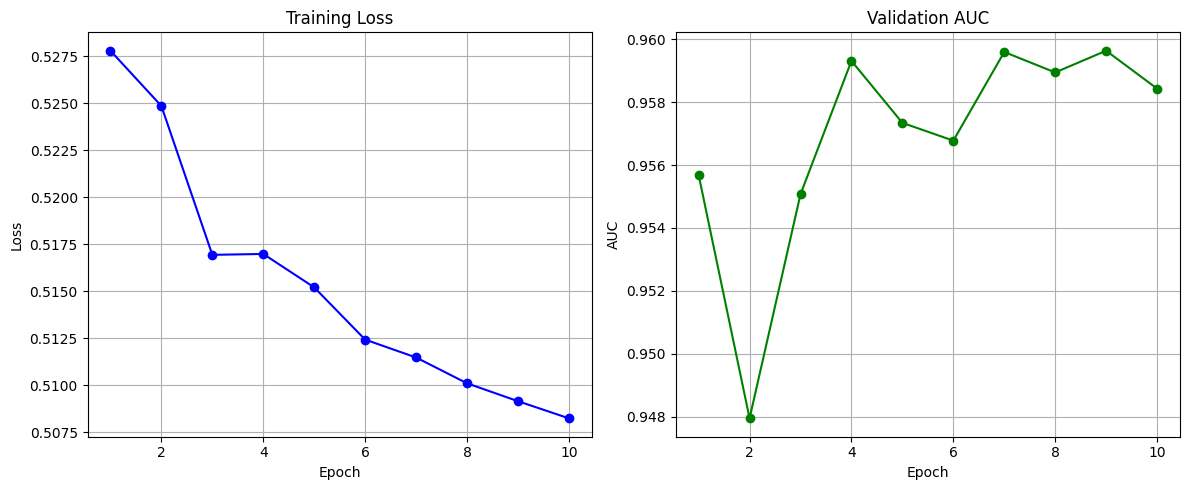

In [8]:
# -------------------------
# 5. Training Logic
# -------------------------
def get_batch_embeddings(src, dst, t):
    """
    Helper to fetch current memory state and compute embeddings.
    """
    z = memory.memory
    last_update = memory.last_update

    z_src, z_dst = z[src], z[dst]
    last_src, last_dst = last_update[src], last_update[dst]

    emb_src = gnn(z_src, last_src, t)
    emb_dst = gnn(z_dst, last_dst, t)
    return emb_src, emb_dst

def train():
    memory.train()
    gnn.train()
    predictor.train()
    memory.reset_state()

    total_loss = 0
    batch_size = 200

    d_src = train_data.src.to(device)
    d_dst = train_data.dst.to(device)
    d_t = train_data.t.to(device)
    d_msg = train_data.msg.to(device)

    num_events = len(train_data)
    num_batches = 0

    for i in tqdm(range(0, num_events, batch_size), desc="Training"):
        batch_idx = slice(i, min(i + batch_size, num_events))
        src, dst = d_src[batch_idx], d_dst[batch_idx]
        t, msg = d_t[batch_idx], d_msg[batch_idx]

        if len(src) == 0: break

        optimizer.zero_grad()
        # 1. Compute embeddings using current memory state
        emb_src, emb_dst = get_batch_embeddings(src, dst, t)
        # 2. Positive Loss (Real edges)
        pos_out = predictor(emb_src, emb_dst)
        pos_loss = criterion(pos_out, torch.ones_like(pos_out))
        # 3. Negative Loss (Random edges)
        rand_dst = torch.randint(0, num_nodes, (len(src),), device=device)
        emb_neg_dst, _ = get_batch_embeddings(rand_dst, rand_dst, t)

        neg_out = predictor(emb_src, emb_neg_dst)
        neg_loss = criterion(neg_out, torch.zeros_like(neg_out))

        loss = pos_loss + neg_loss
        loss.backward()
        optimizer.step()
        # 4. Update Memory
        with torch.no_grad():
            memory.update_state(src, dst, t, msg)
        # 5. Detach Memory
        memory.detach()
        total_loss += loss.item()
        num_batches += 1

    return total_loss / max(1, num_batches)

@torch.no_grad()
def test(inference_data):
    memory.eval()
    gnn.eval()
    predictor.eval()

    d_src = inference_data.src.to(device)
    d_dst = inference_data.dst.to(device)
    d_t = inference_data.t.to(device)
    d_msg = inference_data.msg.to(device)

    total_auc, total_ap = [], []
    total_hits10 = []

    batch_size = 200
    K_neg = 50

    for i in range(0, len(inference_data), batch_size):
        batch_idx = slice(i, min(i + batch_size, len(inference_data)))
        src, dst = d_src[batch_idx], d_dst[batch_idx]
        t, msg = d_t[batch_idx], d_msg[batch_idx]
        current_batch_size = len(src)

        if current_batch_size == 0: break

        # --- 1. Standard AUC/AP ---
        emb_src, emb_dst = get_batch_embeddings(src, dst, t)
        rand_dst = torch.randint(0, num_nodes, (current_batch_size,), device=device)
        emb_neg_dst, _ = get_batch_embeddings(rand_dst, rand_dst, t)

        pos_prob = predictor(emb_src, emb_dst).sigmoid()
        neg_prob = predictor(emb_src, emb_neg_dst).sigmoid()

        y_pred = torch.cat([pos_prob, neg_prob]).cpu().numpy()
        y_true = np.concatenate([np.ones(current_batch_size), np.zeros(current_batch_size)])

        try:
            total_auc.append(roc_auc_score(y_true, y_pred))
            total_ap.append(average_precision_score(y_true, y_pred))
        except ValueError:
            pass

        # --- 2. Ranking Metrics ---
        many_neg_dst = torch.randint(0, num_nodes, (current_batch_size, K_neg), device=device)
        flat_neg_dst = many_neg_dst.view(-1)
        flat_t = t.unsqueeze(1).repeat(1, K_neg).view(-1)

        _, emb_many_negs = get_batch_embeddings(flat_neg_dst, flat_neg_dst, flat_t)
        emb_many_negs = emb_many_negs.view(current_batch_size, K_neg, embedding_dim)
        emb_src_expanded = emb_src.unsqueeze(1).repeat(1, K_neg, 1)

        neg_scores = predictor(emb_src_expanded, emb_many_negs).sigmoid()
        pos_scores = pos_prob.unsqueeze(1)
        rankings = (neg_scores > pos_scores).sum(dim=1) + 1

        total_hits10.append((rankings <= 10).float().mean().item())

        memory.update_state(src, dst, t, msg)

    return np.mean(total_auc), np.mean(total_ap), np.mean(total_hits10)
# -------------------------
# 6. Main Train/Test
# -------------------------
logger.info("Start Training...")
epoch_losses = []
epoch_val_aucs = []

for epoch in range(1, 11):
    loss = train()
    val_auc, val_ap, val_hits = test(val_data)
    epoch_losses.append(loss)
    epoch_val_aucs.append(val_auc)
    logger.info(f'Epoch: {epoch:02d}, Loss: {loss:.4f} | Val AUC: {val_auc:.4f}  AP: {val_ap:.4f}  Hits@10: {val_hits:.4f}')

test_auc, test_ap, test_hits = test(test_data)
logger.info(f'TEST RESULTS | AUC: {test_auc:.4f}  AP: {test_ap:.4f}  Hits@10: {test_hits:.4f}')

plt.figure(figsize=(12, 5))

# Subplot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Subplot 2: Validation AUC
plt.subplot(1, 2, 2)
plt.plot(range(1, len(epoch_val_aucs)+1), epoch_val_aucs, marker='o', label='Val AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation AUC')
plt.grid(True)
plt.tight_layout()

plt.savefig('training_metrics.png')
logger.info("Plot saved to training_metrics.png")